In [ ]:
!pip install lets-plot
!pip install pymc3

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

num_tanks = 1000
num_captured = 15
serial_numbers = np.arange(1, num_tanks + 1)
num_simulations = 100_000

def capture_tanks(serial_numbers, n):
     """Capture `n` tanks, uniformly, at random."""
     return np.random.choice(serial_numbers, n, replace=False)

simulations = [
    capture_tanks(serial_numbers, num_captured)
    for _ in range(num_simulations)
]

The simplest estimate for the number of tanks is simply the maximum number seen. We plot the distribution of this value first and then the average (in red)

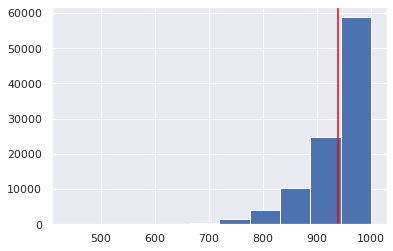

In [9]:
first_estimates = [max(s) for s in simulations]

plt.hist(first_estimates)
avg_first_estimates = np.mean(first_estimates)
plt.axvline(x=avg_first_estimates, color='red')

We see that the average estimate (red line) is less than the total number of tanks. This shows us that the `max(tank_numbers)` is a biased estimator - it will always estimate the number to be less than the actual number of tanks

So, it's clear we need to add something to this number. One intuitive solution is to add the average size of the gap between numbers to `max(tank_number)`

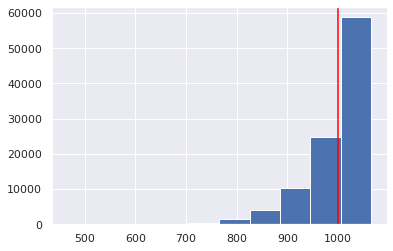

In [5]:
def max_plus_avg_spacing(simulation):
    m = max(simulation)
    avg_spacing = (m / num_captured) - 1 
    return m + avg_spacing

new_estimates = [max_plus_avg_spacing(s) for s in simulations]

plt.hist(new_estimates)
avg_new_estimates = np.mean(new_estimates)
plt.axvline(x=avg_new_estimates, color='red')

In [8]:
avg_new_estimates

999.9626666666666

As we can see, the new estimate is almost exactly equals to 1000. This new estimate is an unbiased estimate of the actual number of tanks.

You can read the derivation of how we can get this estimator and the proof that this is the UMVE from here: https://laurentlessard.com/bookproofs/tank-counting/

In [10]:
# also, the new estimator has a higher variance - this is the bias variance tradeoff

print(np.std(first_estimates))
print(np.std(new_estimates))

58.294202231010935
62.180482379744994


In [11]:
# let's take an example of a sequence of captured tank numbers
# and use it to get the estimate using the new estimator
captured = [499, 505, 190, 427, 185, 572, 818, 721, 
            912, 302, 765, 231, 547, 410, 884]

print(max_plus_avg_spacing(captured))

971.8


Now, we will use PyMC to calculate the poterior probability distribution of the total number of tanks. Let's think of the data generating process:

- Let's call the actual maximum numbers of tanks produced `N`. This `N` would be any random number between `max(tanks_captured)` to some large number (in this case, we're taking the max to be 2000). This can be generated using a `DicreteUniform` prior
- Then, we get the produce tanks numbered: `1, 2, 3, .... N`
- Lastly, we capture some random tanks from this sequence. This can also be modeled using a `DicreteUniform` process with mininum being `1` and maximum being `N`

In [18]:
import pymc3 as pm

with pm.Model():
    num_tanks = pm.DiscreteUniform(
        "num_tanks", 
	    lower=max(captured), 
	    upper=2000
    )
    likelihood = pm.DiscreteUniform(
        "observed", 
	    lower=1,
	    upper=num_tanks, 
	    observed=captured
    )
    posterior = pm.sample(10000, return_inferencedata=True, tune=1000)

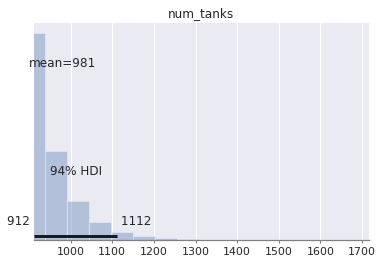

In [19]:
import arviz as az
az.plot_posterior(posterior)

We see that the 94% HDI is between 912 to 1112 tanks with the mean being very close to the actual maximum number of tanks produce (1000)